<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import itertools
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, precision_recall_curve) 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import bernoulli
from scipy.stats import norm
import scipy.stats
import statsmodels.api as sm
import statsmodels.tools.eval_measures as bias
import seaborn as sns
import arviz as az
import pymc3 as pm
import theano.tensor as tt
from IPython.core.pylabtools import figsize
warnings.filterwarnings("ignore")
print(f"Running on PyMC3 v{pm.__version__}")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Running on PyMC3 v3.11.4


#Inferencia Bayesiana
queremos saber las distribuciones de probabilidad de los parámetros desconocidos del modelo.

Probar que tan buenos son unos parámetros. Cuanto mayor sea la probabilidad P(teta|x) de los valores de los parámetros dados los datos, más probable será que sean los parámetros "reales" de la distribución de la población.

Esto significa que podemos transformar nuestro problema de encontrar los parámetros de la distribución de la población, a encontrar los valores de los parámetros que maximizan el valor P(θ|x).

podemos transformar nuestro problema de encontrar los parámetros de la distribución de la población, a encontrar los valores de los parámetros que maximizan el valor P(θ|x).

Leemos los datos para un ejemplo de dos variables

In [2]:
df = pd.read_csv('bones.csv')
df = df.assign(const=1)
#print(df)
dfy = df['frac'] 
dfx = df[['const','sex','age']] ## Predictors
x   = pd.DataFrame(df[['sex','age']]).to_numpy()
y   = pd.DataFrame(df[['frac']]).to_numpy()
df.sample(5)
df.describe()

,sex,age,frac,const
count,100.00,100.000000,100.000000,100.0
mean,0.55,64.980000,0.630000,1.0
std,0.50,8.671304,0.485237,0.0
min,0.00,50.000000,0.000000,1.0
25%,0.00,57.000000,0.000000,1.0
50%,1.00,66.000000,1.000000,1.0
75%,1.00,72.000000,1.000000,1.0
max,1.00,80.000000,1.000000,1.0


## Ejemplo básico de regresión logistica bayesiana
El ejemplo usado es un modelo de regresión logística simulado de fracturas óseas con variables independientes de edad y sexo. Fuente: [Lawrence Joseph](http://www.medicine.mcgill.ca/epidemiology/Joseph/courses/EPIB-621/main.html) [PDF](http://www.medicine.mcgill.ca/epidemiology/joseph/courses/EPIB-621/bayeslogit.pdf)

Al principio no sabemos nada sobre los parámetros `beta` así que usaremos una distribución **uniforme**  con límites suficientemente grandes como los valores: `lower = -10**6; higher = 10**6 `


In [3]:
lower = -10**6; higher = 10**6
with pm.Model() as first_model:
    ## Priors on parameters
    beta_0   = pm.Uniform('beta_0', lower=lower, upper= higher)
    beta_sex = pm.Uniform('beta_sex', lower, higher)
    beta_age = pm.Uniform('beta_age', lower, higher)
    
    #the probability of output equal to 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_sex*df['sex']+ beta_age*df['age']))

with first_model:
    #fit the data 
    observed=pm.Bernoulli("frac", p, observed=df['frac'])
    start = pm.find_MAP()
    step  = pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(25000, step=step, start=start)
    burned_trace=trace[15000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta_age]
>Metropolis: [beta_sex]
>Metropolis: [beta_0]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 61 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


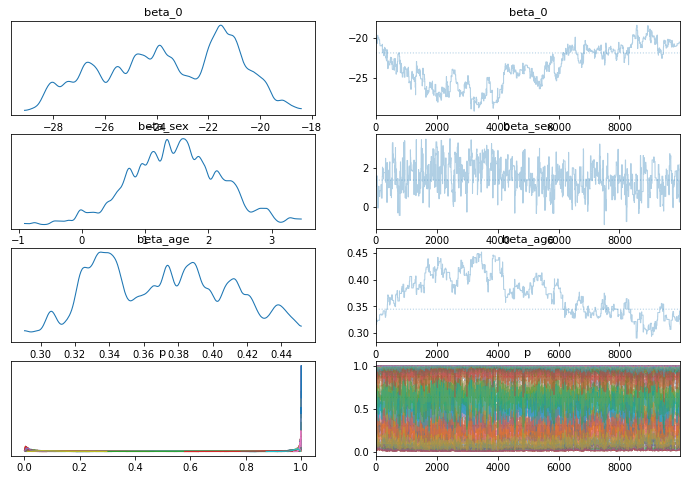

In [4]:
##Graficamos las distribuciones resultantes de nuestro primer modelo
pm.traceplot(burned_trace)
plt.show()

In [5]:
## Ahora calculamos la media de nuestra primera versión de las muestras generadas por la simulación.
coeffs=['beta_0', 'beta_sex', 'beta_age']
d=dict()
for item in coeffs:
    d[item]=[burned_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
result_coeffs
#coeff_result=pd.DataFrame(d)    
#coeff_result

,beta_0,beta_sex,beta_age
0,-22.68537,1.422855,0.357753


Una ventaja del enfoque de inferencia bayesiana es que no solo nos da la media de los parámtros del modelo, también podemos obtener los intervalos de confianza al 95%. Es decir que los Los parámetros buscados se encontrarán entre los valores siguientes con una probabilidad del 95%. 

In [6]:
mean = burned_trace['beta_0'].mean()
hpd = az.hdi(burned_trace['beta_0'].flatten())

coeffs=['beta_0', 'beta_sex', 'beta_age']
interval=dict()
for item in coeffs:
    interval[item]=az.hdi(burned_trace[item].flatten()) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
result_coeffs

,beta_0,beta_sex,beta_age
lower,-27.072815,0.349276,0.320934
upper,-19.740754,2.516089,0.433679


Los valores buscados se encuentran entre estos valores, ahora podemos refinar la búsqueda de los parámetros usando estos límites en un segundo modelo.

In [7]:
with pm.Model() as second_model:
    ## Priors on parameters
    beta_0   = pm.Uniform('beta_0',   lower=-31.561240, upper= -20.376186)
    beta_sex = pm.Uniform('beta_sex', lower=0.555843,   upper=2.816436)
    beta_age = pm.Uniform('beta_age', lower=0.314423,   upper=0.487489)
    
    #the probability of output equal to 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_sex*df['sex']+ beta_age*df['age']))
    
with second_model:
    #fit the data 
    observed=pm.Bernoulli("frac", p, observed=df['frac'])
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(25000, step=step, start=start)
    second_burned_trace=trace[15000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta_age]
>Metropolis: [beta_sex]
>Metropolis: [beta_0]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 42 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


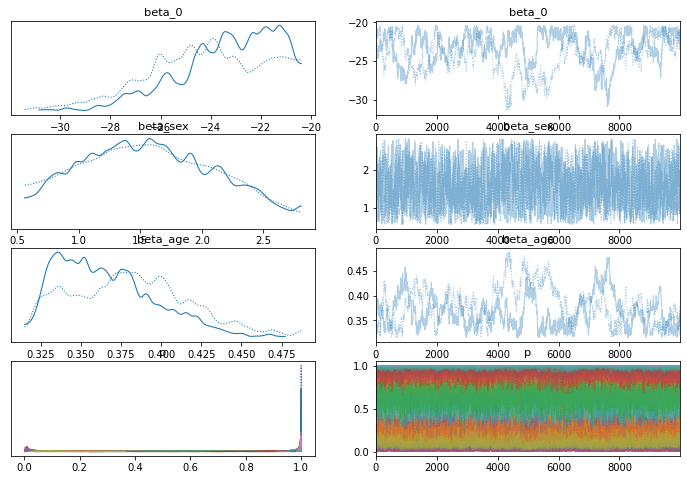

In [8]:
##Graficamos las distribuciones resultantes de nuestro segundo modelo
pm.traceplot(second_burned_trace)
plt.show()

In [9]:
## Ahora calculamos la media de nuestra primera versión de las muestras generadas por la simulación.
coeffs=['beta_0', 'beta_sex', 'beta_age']
d=dict()
for item in coeffs:
    d[item]=[second_burned_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
print(result_coeffs)

      beta_0  beta_sex  beta_age
0 -23.764747  1.572192   0.37384


In [10]:
## Ahora calculamos intervalos al 95%.
mean = second_burned_trace['beta_0'].mean()
hpd = az.hdi(second_burned_trace['beta_0'].flatten())

coeffs=['beta_0', 'beta_sex', 'beta_age']
interval=dict()
for item in coeffs:
    interval[item]=az.hdi(second_burned_trace[item].flatten()) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
print(result_coeffs)

          beta_0  beta_sex  beta_age
lower -27.512536  0.581927  0.316081
upper -20.400437  2.469781  0.432879


Ahora, entrenemos el modelo asumiendo que los coeficientes de la regresión logistica siguen distribuciones normales. Es decir cambiaremos el conjunto de priors en un tercer modelo.

In [18]:
with pm.Model() as thirth_model:  
    ## Priors on parameters
    beta_0   = pm.Normal('beta_0'  , mu=-23.764747, sd=10**4)
    beta_sex = pm.Normal('beta_sex', mu=1.572192, sd=10**4)
    beta_age = pm.Normal('beta_age', mu=0.37384, sd=10**4)
    
    #the probability of output equal to 1
    p = pm.Deterministic('p', pm.math.sigmoid(beta_0+beta_sex*df['sex']+ beta_age*df['age']))
    
with thirth_model:
    #fit the data 
    observed=pm.Bernoulli("frac", p, observed=df['frac'])
    start = pm.find_MAP()
    step = pm.Metropolis()
    
    #samples from posterior distribution 
    trace=pm.sample(25000, step=step, start=start)
    thirth_burned_trace=trace[15000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [beta_age]
>Metropolis: [beta_sex]
>Metropolis: [beta_0]


Sampling 2 chains for 1_000 tune and 25_000 draw iterations (2_000 + 50_000 draws total) took 37 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


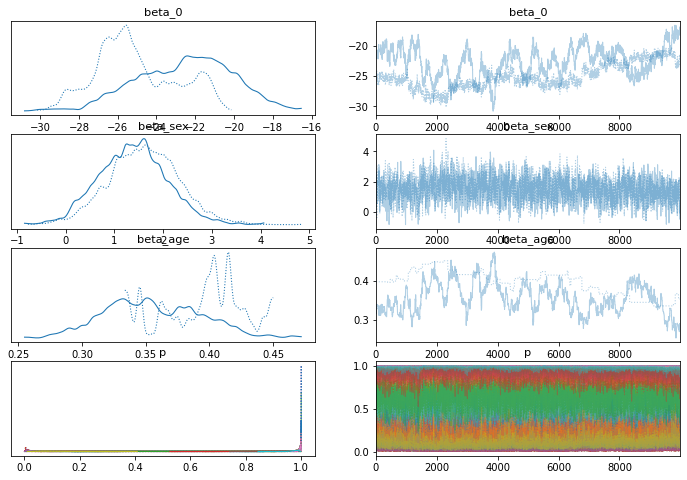

In [19]:
##Graficamos las distribuciones resultantes de nuestro tercer modelo
pm.traceplot(thirth_burned_trace)
plt.show()

In [20]:
## Ahora calculamos la media de nuestra primera versión de las muestras generadas por la simulación.
coeffs=['beta_0', 'beta_sex', 'beta_age']
d=dict()
for item in coeffs:
    d[item]=[thirth_burned_trace[item].mean()]
    
result_coeffs=pd.DataFrame.from_dict(d)    
print(result_coeffs)

      beta_0  beta_sex  beta_age
0 -23.801398  1.493015  0.375394


In [21]:
## Ahora calculamos intervalos al 95%.
mean = thirth_burned_trace['beta_0'].mean()
hpd = az.hdi(thirth_burned_trace['beta_0'].flatten())

coeffs=['beta_0', 'beta_sex', 'beta_age']
interval=dict()
for item in coeffs:
    interval[item]=az.hdi(thirth_burned_trace[item].flatten()) #compute 95% high density interval
    
result_coeffs=pd.DataFrame.from_dict(interval).rename(index={0: 'lower', 1: 'upper'})
print(result_coeffs)

          beta_0  beta_sex  beta_age
lower -28.779861  0.117447  0.308981
upper -19.366825  2.771871  0.447759


Como podemos ver los intervalos son mas cerrados a los que teníamos en el primer modelo. Ahora, podríamos comprar las distribuciones posteriores entre los dos modelos. Por ejemplo, la variable de intercepción `beta_0`.

No handles with labels found to put in legend.


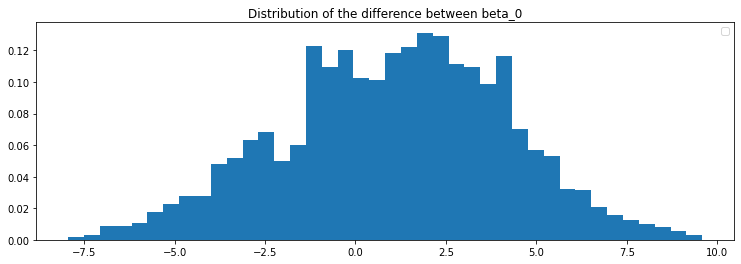

In [22]:
figsize(12.5,4)
plt.hist(burned_trace['beta_0']-second_burned_trace['beta_0'], bins=40, density=True)
plt.title('Distribution of the difference between beta_0')
plt.legend()
plt.show()

## Versión frecuentista de la regresión logística.

Ahora, comparamos los resultados con un análisis frecuentista de regresión logística de la librería **statsmodels**.

In [23]:
model = sm.Logit(dfy, dfx)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.297593
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   frac   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 Feb 2022   Pseudo R-squ.:                  0.5484
Time:                        05:46:49   Log-Likelihood:                -29.759
converged:                       True   LL-Null:                       -65.896
Covariance Type:            nonrobust   LLR p-value:                 2.024e-16
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.8504      4.425     -4.938      0.000     -30.524     -13.177
sex            1.3611      0.

[Bayesian logistic regression with PyMC3](https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a)

[Bayesian Linear Regression in Python via PyMC3](https://towardsdatascience.com/bayesian-linear-regression-in-python-via-pymc3-ab8c2c498211)

[PyMC3](https://docs.pymc.io/en/v3/nb_examples/index.html)

[Logistic regression with PyMC3](https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/)

[Bayesian statistics by Lawrence Joseph (Medicine)](http://www.medicine.mcgill.ca/epidemiology/Joseph/courses/EPIB-621/main.html) [PDF](http://www.medicine.mcgill.ca/epidemiology/joseph/courses/EPIB-621/bayeslogit.pdf)

[Bayesian Learning for Machine Learning: Part II - Linear Regression](https://wso2.com/blog/research/part-two-linear-regression/)

[An Introduction to Logistic Regression in Python](https://www.simplilearn.com/tutorials/machine-learning-tutorial/logistic-regression-in-python)

[Bayesian inference tutorial: a hello world example](https://datapythonista.me/blog/bayesian-inference-tutorial-a-hello-world-example.html)

[Ejemplo de Bayes con covid y síntomas](https://statsthinking21.github.io/statsthinking21-python/10-BayesianStatistics.html)

[Estimating Probabilities with Bayesian Modeling in Python](https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815)

[Estimando probabilidades con inferencia bayesiana](https://github.com/WillKoehrsen/probabilistic-programming/blob/master/Estimating%20Probabilities%20with%20Bayesian%20Inference.ipynb)

Bayesian Linear Regression in Python: Using Machine Learning to Predict Student Grades: [Parte 1](https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-1-7d0ad817fca5) y [Parte2](https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e)

[Bayesian Inference in Python](https://towardsai.net/p/l/bayesian-inference-in-python) 

[Bayesian Statistics explained to Beginners in Simple English](Bayesian Statistics explained to Beginners in Simple English)

[Bayesian inference in Python-coursera](https://www.coursera.org/lecture/advanced-machine-learning-signal-processing/bayesian-inference-in-python-9D2Pz)

[A Guide to Bayesian Statistics in Python for Beginners](https://analyticsindiamag.com/a-guide-to-bayesian-statistics-in-python-for-beginners/)

[BBN: Bayesian Belief Networks — How to Build Them Effectively in Python](https://towardsdatascience.com/bbn-bayesian-belief-networks-how-to-build-them-effectively-in-python-6b7f93435bba)

[Bayesian multivariate linear regression Yni](https://en.wikipedia.org/wiki/Bayesian_multivariate_linear_regression#:~:text=In%20statistics%2C%20Bayesian%20multivariate%20linear,a%20single%20scalar%20random%20variable.)



In [17]:
#https://github.com/nadheesh/bayesian-regression/blob/master/logistic_regression.py
import numpy as np
import pymc3 as pm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from theano import shared, tensor as tt

def invlogit(x):
    """
    sigmoid operator
    :param x: int/float or array like data-structure
    :return: sigmoid of x
    """
    if type(x) is np.ndarray:
        return np.exp(x) / (1 + np.exp(x))
    return tt.exp(x) / (1 + tt.exp(x))

size           = 100 # no of data samples
true_intercept = 0   # intercept of the regression line
true_slope1     = 1   # slop (coefficient) of x
true_slope2     = 1   # slop (coefficient) of x

x1 = np.linspace(0, 1, size)  # generate some random values for x in the given range (0,1)
x2 = np.linspace(0, 1, size)  # generate some random values for x in the given range (0,1)

# performs simple linear regression
# y = sigmoid(a + b*x)
true_regression_line = invlogit(true_intercept + true_slope1 * x1 + true_slope2 * x2)

# we can't use true regression values for training the model
# therefore, add some random noise
y = true_regression_line + np.random.normal(scale=0.3, size=size)

# assume this is a binary classifications
# convert y values to labels
true_regression_line = true_regression_line >= 0.5
y = y >= 0.5

# split the data points into train and test split
x_train, x_test, y_train, y_test, true_y1, true_y2 = train_test_split(x, y, true_regression_line)

# we use a shared variable from theano to feed the x values into the model
# this is need for PPC
# when using the model for predictions we can set this shared variable to x_test
shared_x = shared(x_train)

# training the model
# model specifications in PyMC3 are wrapped in a with-statement
with pm.Model() as model:

    # Define priors
    x_coeff   = pm.Normal('x', 0, sd=20)            # prior for coefficient of x
    intercept = pm.Normal('Intercept', 0, sd=20)  # prior for the intercept
    sigma     = pm.HalfCauchy('sigma', beta=10)       # prior for the error term of due to the noise

    reg = intercept + tt.dot(shared_x, x_coeff)
    p = pm.Deterministic("p", invlogit(reg))      # represent the logistic regression relationship

    # Define likelihood
    likelihood = pm.Bernoulli('y', p=p, observed=y_train)

    # Inference!
    trace = pm.sample(1000)  # draw 3000 posterior samples using NUTS sampling

# predicting the unseen y values
# uses posterior predictive checks (PPC)
shared_x.set_value(x_test)  # let's set the shared x to the test dataset
ppc = pm.sample_posterior_predictive(trace, model=model, samples=1000)  # performs PPC
predictions = ppc['y'].mean(axis=0)  # compute the mean of the samples draws from each new y

predictions = predictions >= 0.5
# now you can check the error
#print("Accuracy of logistic regression using bayesian : {0}".format(accuracy_score(y_test, predictions))) ##error

# plot the traceplot
pm.traceplot(trace)


ValueError: ignored